In [1]:
from collections import OrderedDict
from os import getpid
from pprint import pprint
from shutil import rmtree
from time import sleep

from jcarbon.client import JCarbonClient
from jcarbon.tensorflow.callbacks import JCarbonEpochCallback

2024-05-06 22:07:10.238079: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 22:07:10.238153: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 22:07:10.239125: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-06 22:07:10.246814: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 22:07:11.619281: W tensorflow/compiler/tf2

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
(img_train, label_train), (img_test, label_test) = keras.datasets.fashion_mnist.load_data()

# Normalize pixel values between 0 and 1
img_train = img_train.astype('float32') / 255.0
img_test = img_test.astype('float32') / 255.0

In [4]:
jcarbon_callback = JCarbonEpochCallback()

In [5]:
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(28, 28)))
model.add(keras.layers.Dense(units=32, activation='relu'))
model.add(keras.layers.Dense(10))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-2),
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

2024-05-06 22:07:14.141924: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-06 22:07:14.428255: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-06 22:07:14.428378: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-06 22:07:14.432924: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-06 22:07:14.433063: I external/local_xla/xla/stream_executor

In [6]:
result = model.fit(
    img_train,
    label_train,
    epochs=50,
    callbacks=[jcarbon_callback],
)

2024-05-06 22:07:15.440273: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.
2024-05-06 22:07:15.600632: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


Epoch 1/5


2024-05-06 22:07:16.705320: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fbd67662b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-06 22:07:16.705372: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-05-06 22:07:16.726742: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-06 22:07:16.780901: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1715054836.926949  118906 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1875/1875 [==============================] - 14s 6ms/step - loss: 0.5501 - accuracy: 0.8009 - jcarbon-epoch-jcarbon.cpu.eflect.ProcessEnergy-JOULES: 1003.8922 - jcarbon-epoch-jcarbon.emissions.Emissions-GRAMS_OF_CO2: 0.2571
Epoch 2/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.4521 - accuracy: 0.8375 - jcarbon-epoch-jcarbon.cpu.eflect.ProcessEnergy-JOULES: 902.1118 - jcarbon-epoch-jcarbon.emissions.Emissions-GRAMS_OF_CO2: 0.2260
Epoch 3/5
1875/1875 [==============================] - 12s 7ms/step - loss: 0.4328 - accuracy: 0.8417 - jcarbon-epoch-jcarbon.cpu.eflect.ProcessEnergy-JOULES: 906.6989 - jcarbon-epoch-jcarbon.emissions.Emissions-GRAMS_OF_CO2: 0.2317
Epoch 4/5
1875/1875 [==============================] - 12s 7ms/step - loss: 0.4261 - accuracy: 0.8459 - jcarbon-epoch-jcarbon.cpu.eflect.ProcessEnergy-JOULES: 938.2882 - jcarbon-epoch-jcarbon.emissions.Emissions-GRAMS_OF_CO2: 0.2360
Epoch 5/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0

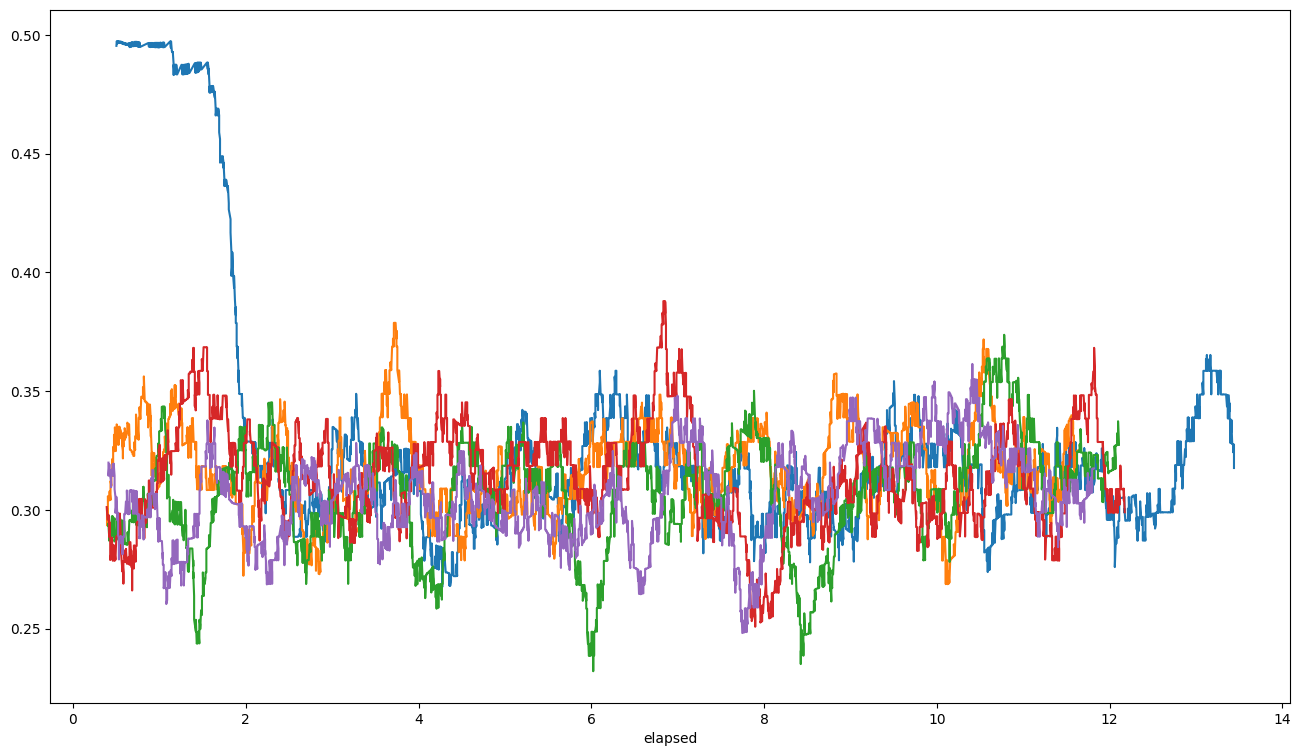

In [50]:
signal = 'jcarbon.cpu.eflect.ProcessEnergy'
ax=None
for report in jcarbon_callback.reports:
    df = report.reset_index()
    df = df[df.signal == signal]
    df['elapsed'] = (df.start - df.start.min()).dt.total_seconds()
    df['rolled_value'] = df['value'].rolling(100).mean()
    ax = df.plot(x='elapsed', y='rolled_value', legend=False, figsize=(16, 9), ax=ax)